In [3]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(r'C:\Users\Admin\Desktop\Havartechs\Projects\Telecommunication\Tellco_Analysis\scripts')))
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
#from CleanTelecomData import clean_telecom_data
from helper import TelecomHelper
from plots import plots

import plotly.express as px

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Load the cleaned dataframe

In [4]:
CSV_PATH = r"C:\Users\Admin\Desktop\Havartechs\Projects\Telecommunication\Tellco_Analysis\Data\cleaned_data.csv"

In [5]:
TelecomHelper = TelecomHelper()

In [6]:
df = TelecomHelper.read_csv(CSV_PATH)

file read as csv


### Change the handset_type and the msisdn to categorical type

In [7]:
df['msisdn/number'] = df['msisdn/number'].astype("int")
df['msisdn/number'] = df['msisdn/number'].astype("category")

df['handset_type'] = df['handset_type'].astype("category")
cleaned_df = df

In [8]:
experience_df = cleaned_df[['msisdn/number', 'avg_rtt_dl_(ms)', 'avg_rtt_ul_(ms)', 
           'avg_bearer_tp_dl_(kbps)', 'avg_bearer_tp_ul_(kbps)',
           'tcp_ul_retrans._vol_(bytes)', 'tcp_dl_retrans._vol_(bytes)',
           'handset_type']]

experience_df.head()

,msisdn/number,avg_rtt_dl_(ms),avg_rtt_ul_(ms),avg_bearer_tp_dl_(kbps),avg_bearer_tp_ul_(kbps),tcp_ul_retrans._vol_(bytes),tcp_dl_retrans._vol_(bytes),handset_type
0,-2147483648,42.000000,5.000000,23.0,44.0,772902.274842,2.105238e+07,Samsung Galaxy A5 Sm-A520F
1,-2147483648,65.000000,5.000000,16.0,26.0,772902.274842,2.105238e+07,Samsung Galaxy J5 (Sm-J530)
2,-2147483648,105.959783,17.633655,6.0,9.0,772902.274842,2.105238e+07,Samsung Galaxy A8 (2018)
3,-2147483648,105.959783,17.633655,44.0,44.0,772902.274842,2.105238e+07,Samsung Galaxy A8 (2018)
4,-2147483648,105.959783,17.633655,6.0,9.0,772902.274842,2.105238e+07,Samsung Sm-G390F


In [9]:
#handling outlier by replacing them with mean and mode
def handle_outliers(df, col, method="lower_upper"):
    df = df.copy()
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    
    lower_bound = q1 - ((1.5) * (q3 - q1))
    upper_bound = q3 + ((1.5) * (q3 - q1))
    
    if method == "mean":
        df[col] = np.where(df[col] < lower_bound,   df[col].mean(), df[col])
        df[col] = np.where(df[col] > upper_bound, df[col].mean(), df[col])
    
    elif  method == "mode":
        df[col] = np.where(df[col] < lower_bound,   df[col].mode()[0], df[col])
        df[col] = np.where(df[col] > upper_bound, df[col].mode()[0], df[col])
    else:
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    
    return df

In [10]:
# Extracting and constructructing our experience metrics
cleaned_experience_df = handle_outliers(experience_df, 'avg_rtt_dl_(ms)', method="mean")
cleaned_experience_df = handle_outliers(experience_df, 'avg_rtt_ul_(ms)', method="mean")

cleaned_experience_df = handle_outliers(experience_df, 'avg_bearer_tp_dl_(kbps)', method="mean")
cleaned_experience_df = handle_outliers(experience_df, 'avg_bearer_tp_ul_(kbps)', method="mean")

cleaned_experience_df = handle_outliers(experience_df, 'tcp_ul_retrans._vol_(bytes)', method="mean")
cleaned_experience_df = handle_outliers(experience_df, 'tcp_dl_retrans._vol_(bytes)', method="mean")


In [11]:
experience_metrics_df = pd.DataFrame(columns=['msisdn', 'handset_type', 'avg_rtt_ms',
                                              'avg_throughput_kbps', 'tcp_retrans_bytes'])

experience_metrics_df['avg_rtt_ms'] = cleaned_experience_df['avg_rtt_dl_(ms)'] + cleaned_experience_df['avg_rtt_ul_(ms)']
experience_metrics_df['avg_throughput_kbps'] = cleaned_experience_df['avg_bearer_tp_dl_(kbps)'] + cleaned_experience_df['avg_bearer_tp_ul_(kbps)']
experience_metrics_df['tcp_retrans_bytes'] = cleaned_experience_df['tcp_ul_retrans._vol_(bytes)'] + cleaned_experience_df['tcp_dl_retrans._vol_(bytes)']

experience_metrics_df['msisdn'] = cleaned_experience_df['msisdn/number']
experience_metrics_df['handset_type'] = cleaned_experience_df['handset_type']

In [12]:
experience_metrics_df.head()

,msisdn,handset_type,avg_rtt_ms,avg_throughput_kbps,tcp_retrans_bytes
0,-2147483648,Samsung Galaxy A5 Sm-A520F,47.000000,67.0,2.182528e+07
1,-2147483648,Samsung Galaxy J5 (Sm-J530),70.000000,42.0,2.182528e+07
2,-2147483648,Samsung Galaxy A8 (2018),123.593439,15.0,2.182528e+07
3,-2147483648,Samsung Galaxy A8 (2018),123.593439,88.0,2.182528e+07
4,-2147483648,Samsung Sm-G390F,123.593439,15.0,2.182528e+07


In [13]:
experience_metrics_df.describe()

,avg_rtt_ms,avg_throughput_kbps,tcp_retrans_bytes
count,146891.000000,146891.000000,1.468910e+05
mean,123.593439,15207.646609,1.488153e+07
std,537.295718,26952.835523,1.878126e+07
min,0.000000,0.000000,8.600000e+01
25%,40.000000,90.000000,1.521045e+06
50%,66.000000,126.000000,2.182528e+07
75%,123.593439,22702.500000,2.182528e+07
max,96924.000000,382262.000000,2.913408e+09


In [14]:
# Task 3.1, aggregate, average, average RTT, handset type, through output per customer
experience_agg_by_customer = experience_metrics_df.groupby('msisdn').agg({'avg_rtt_ms': 'sum',
                                                                          'avg_throughput_kbps': 'sum',
                                                                          'tcp_retrans_bytes': 'sum', 
                                                                           'handset_type': lambda x: x.mode()[0]})


In [15]:
experience_agg_by_customer = handle_outliers(experience_agg_by_customer, 'avg_rtt_ms', method="mean")

experience_agg_by_customer = handle_outliers(experience_agg_by_customer, 'avg_throughput_kbps', method="mean")

experience_agg_by_customer = handle_outliers(experience_agg_by_customer, 'tcp_retrans_bytes', method="mean")


In [16]:
experience_agg_by_customer.head(10)

,avg_rtt_ms,avg_throughput_kbps,tcp_retrans_bytes,handset_type
msisdn,,,,
-2147483648,1.815476e+07,2.233866e+09,2.185963e+12,Huawei B528S-23A


In [17]:
tcp_trans = experience_metrics_df.sort_values(by=['tcp_retrans_bytes'], ascending=False)

top_10_tcp = tcp_trans.head(10)
bot_10_tcp = tcp_trans.tail(10)
most_tcp_frq = tcp_trans['tcp_retrans_bytes'].value_counts().head(10)

In [18]:
top_10_tcp[['tcp_retrans_bytes']]

,tcp_retrans_bytes
34986,2.913408e+09
74941,2.639770e+09
65724,2.464814e+09
1465,2.260712e+09
130390,1.772436e+09
33938,1.748862e+09
139207,1.239951e+09
139416,7.949480e+08
64506,7.406242e+08
1346,5.293231e+08


In [19]:
bot_10_tcp[['tcp_retrans_bytes']]

,tcp_retrans_bytes
12477,143.0
81400,134.0
93685,134.0
97528,129.0
8580,128.0
94746,113.0
12759,108.0
17773,106.0
108566,97.0
140565,86.0


In [20]:
most_tcp_frq

tcp_retrans_bytes
2.182528e+07    83625
2.105367e+07      649
7.742323e+05      245
2.105371e+07      241
2.105370e+07      137
7.729403e+05      136
7.729943e+05      126
7.755623e+05      114
7.742203e+05      104
2.105504e+07      100
Name: count, dtype: int64

In [21]:
tcp_rtt = experience_agg_by_customer.sort_values(by=['avg_rtt_ms'], ascending=False)

top_10_rtt = tcp_rtt.head(10)
bot_10_rtt = tcp_rtt.tail(10)

In [22]:
tcp_rtt = experience_agg_by_customer.sort_values(by=['avg_rtt_ms'], ascending=False)

top_10_rtt = tcp_rtt.head(10)
bot_10_rtt = tcp_rtt.tail(10)

In [23]:
bot_10_rtt[['avg_rtt_ms']]

,avg_rtt_ms
msisdn,
-2147483648,1.815476e+07


In [24]:
tcp_rtt = experience_agg_by_customer.sort_values(by=['avg_rtt_ms'], ascending=False)

top_10_rtt = tcp_rtt.head(10)
bot_10_rtt = tcp_rtt.tail(10)
most_rtt_frq = tcp_rtt['avg_rtt_ms'].value_counts().head(10)

In [25]:
top_10_rtt[['avg_rtt_ms']]

,avg_rtt_ms
msisdn,
-2147483648,1.815476e+07


In [26]:
bot_10_rtt[['avg_rtt_ms']]

,avg_rtt_ms
msisdn,
-2147483648,1.815476e+07


In [27]:
most_rtt_frq

avg_rtt_ms
1.815476e+07    1
Name: count, dtype: int64

In [28]:
tcp_throuput = experience_agg_by_customer.sort_values(by=['avg_throughput_kbps'], ascending=False)

top_10_throuput = tcp_throuput.head(10)
bot_10_throuput = tcp_throuput.tail(10)
frq_throuput = tcp_throuput['avg_throughput_kbps'].value_counts().head(10)

In [29]:
top_10_throuput[['avg_throughput_kbps']]

,avg_throughput_kbps
msisdn,
-2147483648,2.233866e+09


In [30]:
bot_10_throuput[['avg_throughput_kbps']]

,avg_throughput_kbps
msisdn,
-2147483648,2.233866e+09


In [31]:
frq_throuput

avg_throughput_kbps
2.233866e+09    1
Name: count, dtype: int64

## Task 3.3
The distribution of the average throughput per handset type and provide interpretation for your findings.

In [32]:
handset_agg = experience_metrics_df.groupby('handset_type').agg({'avg_throughput_kbps': 'sum',
                                                                       'tcp_retrans_bytes': 'sum'})

sorted_handset_agg = handset_agg.sort_values(by=['avg_throughput_kbps'], ascending=False).head(10)

handset_tp_df = sorted_handset_agg[['avg_throughput_kbps']]
handset_tp_df['handset_type'] = sorted_handset_agg.index

# handset_tp_df

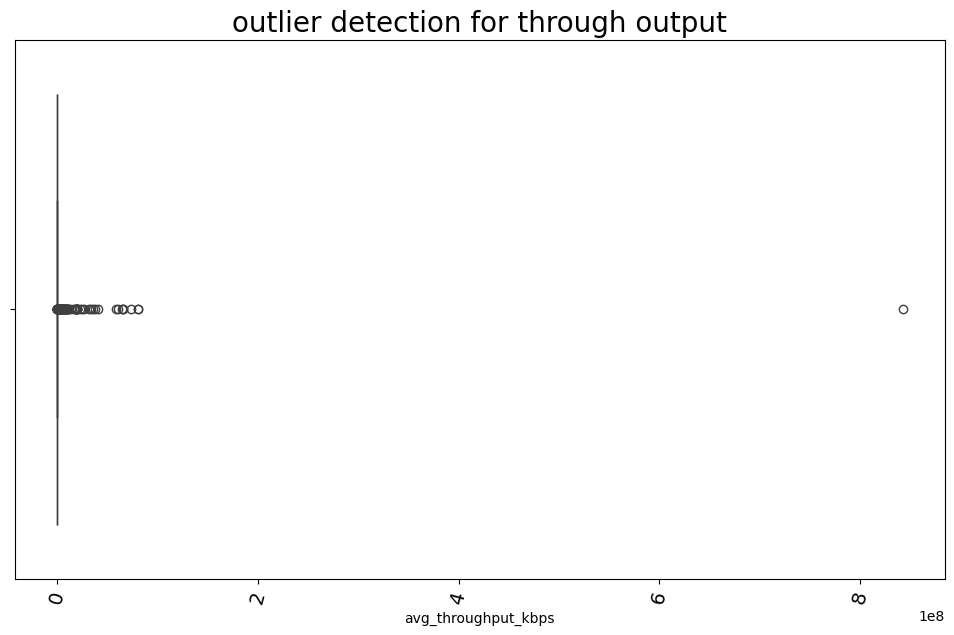

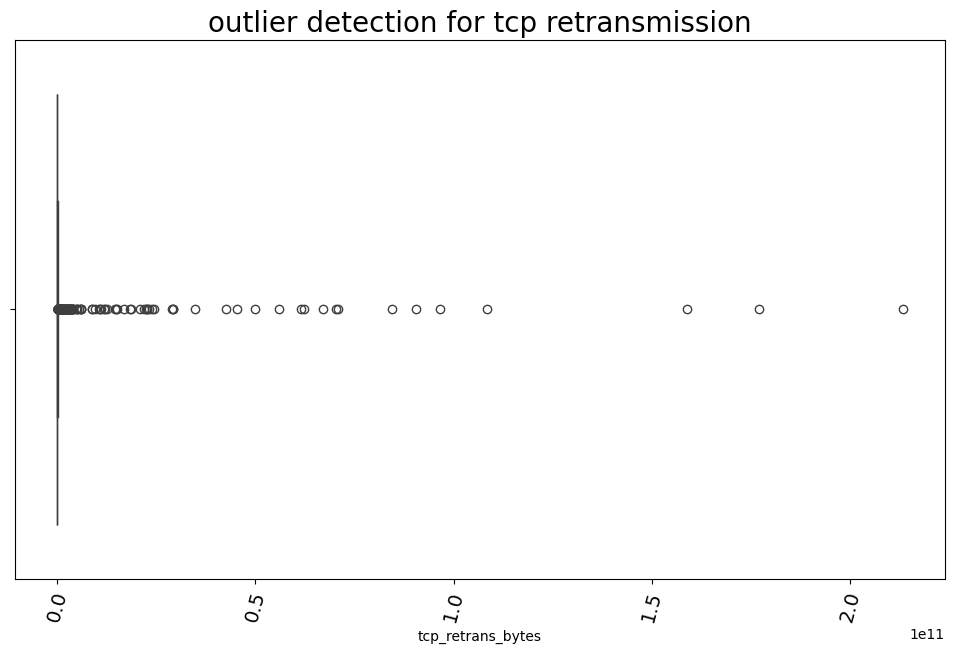

In [33]:
plots.plot_box(handset_agg, 'avg_throughput_kbps', 'outlier detection for through output')
plots.plot_box(handset_agg, 'tcp_retrans_bytes', 'outlier detection for tcp retransmission')

<Figure size 900x700 with 0 Axes>

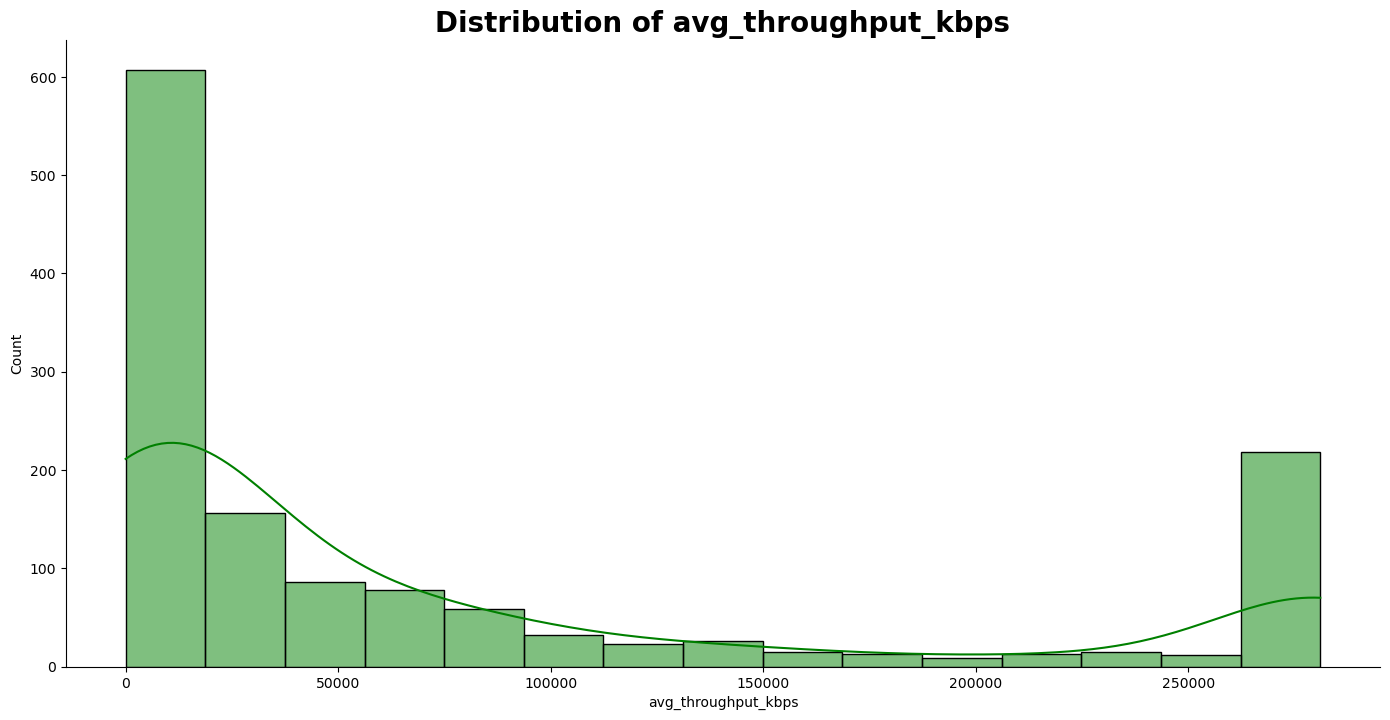

,avg_throughput_kbps,tcp_retrans_bytes
count,1362.000000,1.362000e+03
mean,79224.963656,1.604965e+09
std,102278.044997,1.142878e+10
min,0.000000,3.600000e+02
25%,3450.750000,1.442044e+06
50%,26541.500000,2.182528e+07
75%,114507.500000,6.938803e+07
max,281092.625000,2.132877e+11


In [34]:
cleaned_handset_agg =  handle_outliers(handset_agg, 'avg_throughput_kbps')

plots.plot_hist(cleaned_handset_agg, 'avg_throughput_kbps', 'green')
cleaned_handset_agg.describe()

<Figure size 900x700 with 0 Axes>

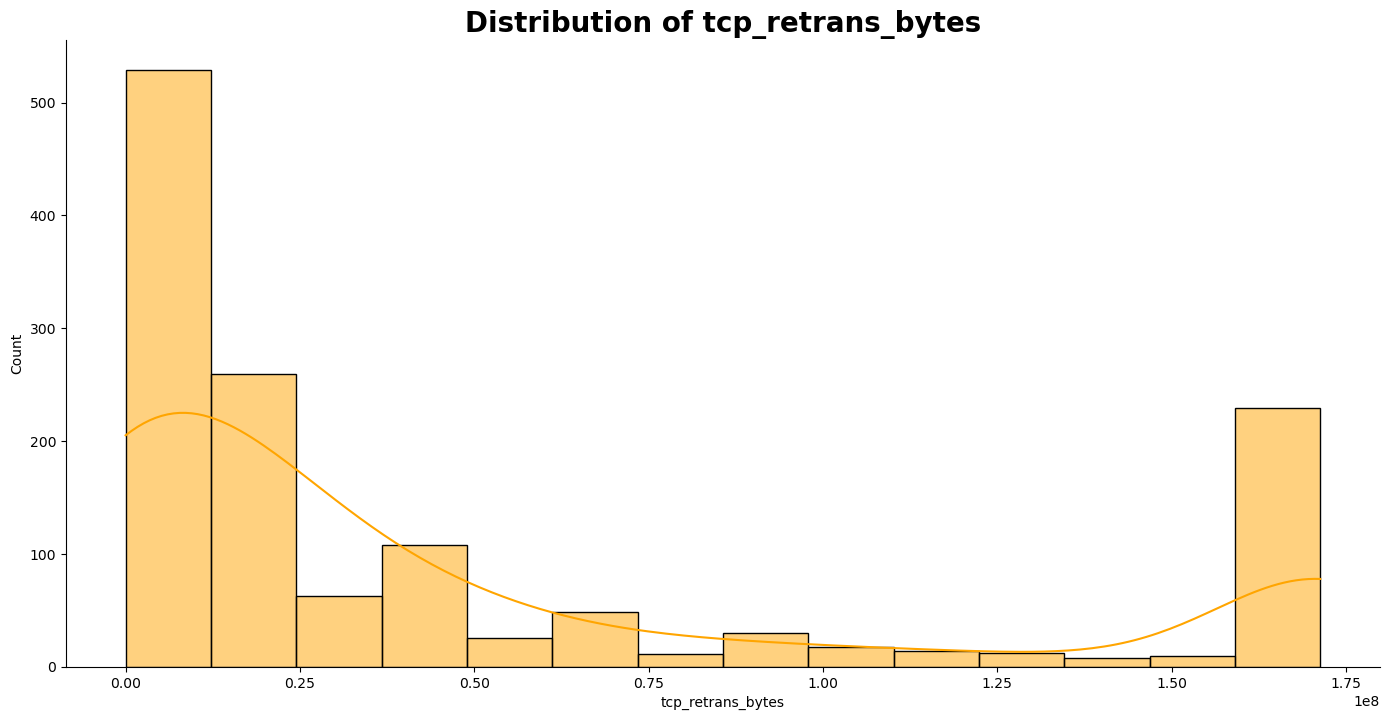

,avg_throughput_kbps,tcp_retrans_bytes
count,1.362000e+03,1.362000e+03
mean,1.640137e+06,4.995038e+07
std,2.360348e+07,6.208771e+07
min,0.000000e+00,3.600000e+02
25%,3.450750e+03,1.442044e+06
50%,2.654150e+04,2.182528e+07
75%,1.145075e+05,6.938803e+07
max,8.425110e+08,1.713070e+08


In [48]:
cleaned_handset_agg =  handle_outliers(handset_agg, 'tcp_retrans_bytes')
plots.plot_hist(cleaned_handset_agg, 'tcp_retrans_bytes', 'orange')
cleaned_handset_agg.describe()

Both Through out put and tcp retransmission seems to be directly related. since they have the same type of distrbution

### Task 3.4
Using the experience metrics above, perform a k-means clustering (where k = 3) to segment users into groups of experiences

In [44]:
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.cluster import KMeans


def normalizer(df, columns):
    norm = Normalizer()
    return pd.DataFrame(norm.fit_transform(df), columns=columns)

def scaler(df, columns):
    minmax_scaler = MinMaxScaler()
    return pd.DataFrame(minmax_scaler.fit_transform(df), columns=columns)

def scale_and_normalize(df,columns ):
    return normalizer(scaler(df, columns), columns)

In [45]:
def cluster_label(x: int, cols: list = []) -> str:
    if (not type(x) == int):
        return x
    if (x < len(cols)):
        return cols[x]

    return str(x)

In [46]:
# Normalization
metrics = experience_agg_by_customer[['avg_rtt_ms', 'avg_throughput_kbps', 'tcp_retrans_bytes']]

# handling outliers
metrics_cleaned = metrics.copy()
metrics_cleaned = handle_outliers(metrics_cleaned, 'avg_rtt_ms', 'mean')
metrics_cleaned = handle_outliers(metrics_cleaned, 'avg_throughput_kbps', 'mean')
metrics_cleaned = handle_outliers(metrics_cleaned, 'tcp_retrans_bytes', 'mean')

normalized_metrics = scaler(metrics_cleaned, ['avg_rtt_ms', 'avg_throughput_kbps', 'tcp_retrans_bytes'])
normalized_metrics.describe()

,avg_rtt_ms,avg_throughput_kbps,tcp_retrans_bytes
count,1.0,1.0,1.0
mean,0.0,0.0,0.0
std,NaN,NaN,NaN
min,0.0,0.0,0.0
25%,0.0,0.0,0.0
50%,0.0,0.0,0.0
75%,0.0,0.0,0.0
max,0.0,0.0,0.0


In [43]:
metrics.head()

,avg_rtt_ms,avg_throughput_kbps,tcp_retrans_bytes
msisdn,,,
-2147483648,1.815476e+07,2.233866e+09,2.185963e+12


In [42]:
normalized_metrics.head()

,avg_rtt_ms,avg_throughput_kbps,tcp_retrans_bytes
0,0.0,0.0,0.0


In [40]:
# Before check the data
print(f"Shape of normalized_metrics: {normalized_metrics.shape}")
print(f"Number of samples in normalized_metrics: {len(normalized_metrics)}")

Shape of normalized_metrics: (1, 3)
Number of samples in normalized_metrics: 1


In [41]:
kmeans = KMeans(n_clusters=3, init='k-means++').fit(normalized_metrics)

ValueError: n_samples=1 should be >= n_clusters=3.

In [39]:
kmeans = KMeans(n_clusters=3, init='k-means++').fit(normalized_metrics)
pred = kmeans.predict(normalized_metrics)

experience_metrics_with_cluster = experience_agg_by_customer.copy()
experience_metrics_with_cluster['clusters'] = pred
experience_metrics_with_cluster['clusters'].value_counts()

ValueError: n_samples=1 should be >= n_clusters=3.

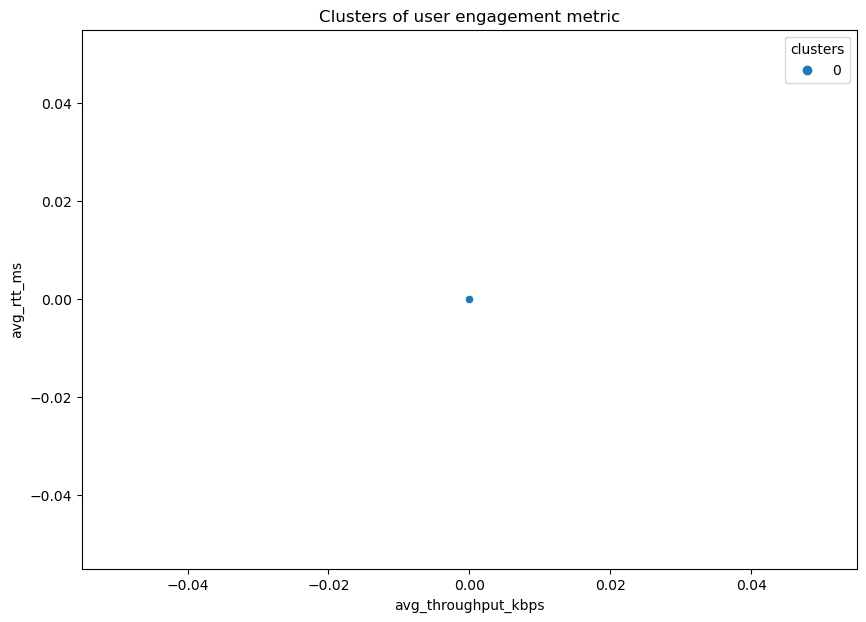

In [106]:

normalized_metrics['clusters'] = pred
plt.figure(figsize=(10,7))

sns.scatterplot(x = 'avg_throughput_kbps', y='avg_rtt_ms',
                hue='clusters', data=normalized_metrics).set_title('Clusters of user engagement metric')

plt.show()

In [107]:
TelecomHelper.save_csv(experience_metrics_with_cluster, '../data/user_experience_metrics.csv')

File Successfully Saved.!!!


,avg_rtt_ms,avg_throughput_kbps,tcp_retrans_bytes,handset_type,clusters
msisdn,,,,,
-2147483648,1.815476e+07,2.233866e+09,2.185963e+12,Huawei B528S-23A,0


In [108]:
normal_metrics_with_cluster_2 = normalized_metrics.copy()
kmeans

KMeans(n_clusters=1)

In [109]:
distance = kmeans.fit_transform(normal_metrics_with_cluster_2)

distance_from_less_exp = list(map(lambda x : x[0], distance))

experience_metrics_with_cluster_2 = experience_metrics_with_cluster.copy()
experience_metrics_with_cluster_2['score'] = distance_from_less_exp

In [110]:
experience_metrics_with_cluster_2['msisdn'] = experience_metrics_with_cluster_2.index